In [1]:
import pandas as pd
import numpy as np


# 读取数据
train = pd.read_csv('4577.csv')


In [2]:
train.columns

Index(['unique_id', 'date', 'total_orders', 'sales', 'sell_price_main',
       'holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays',
       'month_sin', 'month_cos', 'day_sin', 'day_cos', 'is_discount',
       'max_discount', 'is_weekend', 'warehouse_total_orders',
       'warehouse_weekday_sales_mean', 'warehouse_mean',
       'holiday_name_total_orders', 'holiday_name_weekday_sales_mean',
       'holiday_name_mean', 'L1_category_name_en_total_orders',
       'L1_category_name_en_weekday_sales_mean', 'L1_category_name_en_mean',
       'year_mean', 'name_mean', 'L2_category_name_en_mean',
       'L3_category_name_en_mean', 'L4_category_name_en_mean',
       'warehouse_Budapest_1', 'warehouse_Frankfurt_1', 'warehouse_Munich_1',
       'warehouse_Prague_1', 'warehouse_Prague_2', 'warehouse_Prague_3',
       'L1_category_name_en_Fruit and vegetable',
       'L1_category_name_en_Meat and fish', 'year_year_2021', 'year_year_2022',
       'year_year_2023', 'year_year_2024',

In [4]:
# train.drop(['month_sin','month_cos'], axis=1, inplace=True)
# train.drop(['warehouse_total_orders','L1_category_name_en_total_orders','holiday_name_total_orders'], axis=1, inplace=True)
# train.drop(['month_10', 'month_11', 'month_12',
#        'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
#        'month_8', 'month_9'], axis=1, inplace=True)
# train.drop(['holiday_name_total_orders','warehouse_total_orders','L1_category_name_en_total_orders'], axis=1, inplace=True)
# train.drop(['warehouse_monthly_sales_mean','holiday_name_monthly_sales_mean','L1_category_name_en_monthly_sales_mean'], axis=1, inplace=True)
# train.drop(['L1_category_name_en_weekday_sales_mean','warehouse_weekday_sales_mean','holiday_name_weekday_sales_mean'], axis=1, inplace=True)
# train.drop(['weekday_1', 'weekday_2', 'weekday_3',
#        'weekday_4', 'weekday_5', 'weekday_6'], axis=1, inplace=True)
train.drop(['warehouse_total_orders', 
       'warehouse_weekday_sales_mean', 'warehouse_mean',
       'holiday_name_total_orders', 
       'holiday_name_weekday_sales_mean', 'holiday_name_mean',
       'L1_category_name_en_total_orders',
       
       'L1_category_name_en_weekday_sales_mean', 'L1_category_name_en_mean',
       'year_mean', 'name_mean', 'L2_category_name_en_mean',
       'L3_category_name_en_mean', 'L4_category_name_en_mean'], axis=1, inplace=True)

In [5]:
train['date'] = pd.to_datetime(train['date'])
# 定义验证集的日期范围
val_start_date1 = pd.to_datetime('2023-06-03')
val_end_date1 = pd.to_datetime('2023-06-16')

val_start_date2 = pd.to_datetime('2024-05-03')
val_end_date2 = pd.to_datetime('2024-06-03')

# 划分第一个验证集
val1 = train[(train['date'] >= val_start_date1) & (train['date'] <= val_end_date1)]  # 2023-06-03 到 2023-06-16 的数据

# 划分第二个验证集
val2 = train[(train['date'] >= val_start_date2) & (train['date'] <= val_end_date2)]  # 2024-05-03 到 2024-06-03 的数据

# 合并两个验证集
val = pd.concat([val1, val2])

# 划分训练集
# 训练集是除了两个验证集之外的数据
train_before_val1 = train[train['date'] < val_start_date1]  # 第一个验证集之前的数据
train_between_vals = train[(train['date'] > val_end_date1) & (train['date'] < val_start_date2)]  # 两个验证集之间的数据
train_after_val2 = train[train['date'] > val_end_date2]  # 第二个验证集之后的数据

# 合并训练集
train = pd.concat([train_before_val1, train_between_vals, train_after_val2])

# 检查数据量
print("训练集数据量：", len(train))
print("验证集数据量：", len(val))

训练集数据量： 1357
验证集数据量： 45


In [6]:
train_date = train['date']
val_date = val['date']
train.drop(['unique_id','date'], axis=1, inplace=True)
val.drop(['unique_id','date'], axis=1, inplace=True)
y_train = train['sales']
y_val = val['sales']
train = train.drop(columns=['sales'])
val = val.drop(columns=['sales'])
y_train

0       123.38
1       133.97
2       310.27
3        88.82
4       146.27
         ...  
1388     62.88
1392     92.46
1393     86.66
1396    104.64
1400    102.73
Name: sales, Length: 1357, dtype: float64

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1357 entries, 0 to 1400
Data columns (total 42 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   total_orders                             1357 non-null   float64
 1   sell_price_main                          1357 non-null   float64
 2   holiday                                  1357 non-null   bool   
 3   shops_closed                             1357 non-null   bool   
 4   winter_school_holidays                   1357 non-null   bool   
 5   school_holidays                          1357 non-null   bool   
 6   month_sin                                1357 non-null   float64
 7   month_cos                                1357 non-null   float64
 8   day_sin                                  1357 non-null   float64
 9   day_cos                                  1357 non-null   float64
 10  is_discount                              1357 non-nul

In [8]:
import lightgbm as lgb
# 创建 LightGBM 数据集
train_data = lgb.Dataset(train, label=y_train)
test_data = lgb.Dataset(val, label=y_val, reference=train_data)

In [23]:
# 定义 LightGBM 参数
params = {
    'boosting_type': 'gbdt',          # 提升类型：gbdt（梯度提升决策树）
    'objective': 'regression',        # 目标函数：回归任务
    'metric': 'mae',                 # 评估指标：均方根误差
    'num_leaves': 500,                 # 每棵树的最大叶子数
    'learning_rate': 0.02,            # 学习率
    'feature_fraction': 0.8,          # 每次迭代时随机选择 90% 的特征
    'bagging_fraction': 0.8,          # 每次迭代时随机选择 80% 的数据
    'bagging_freq': 10,                # 每 5 次迭代进行一次 bagging
    'verbose': -1,                    # 不输出日志信息
    'seed': 42,                       # 随机种子
    'num_threads': -1,                # 使用所有可用的 CPU 核心
    'max_depth': None,                  # 树的最大深度，-1 表示不限制
    'min_data_in_leaf': 5,           # 叶节点最小样本数
    'lambda_l1': 1,                 # L1 正则化
    'lambda_l2': 0.5,                 # L2 正则化
    'device': 'gpu',                  # 使用 CPU 或 GPU（设置为 'gpu' 以启用 GPU 加速）
}

In [24]:
# 训练模型
num_round = 600  # 迭代次数
model = lgb.train(
    params,
    train_data,
    num_round,
    valid_sets=[test_data],
    callbacks=[lgb.log_evaluation(period=20)],  # 每 20 步输出一次
)

[20]	valid_0's l1: 34.7578
[40]	valid_0's l1: 28.4567
[60]	valid_0's l1: 25.0866
[80]	valid_0's l1: 23.2227
[100]	valid_0's l1: 21.9824
[120]	valid_0's l1: 21.0335
[140]	valid_0's l1: 20.7821
[160]	valid_0's l1: 20.546
[180]	valid_0's l1: 20.217
[200]	valid_0's l1: 20.2091
[220]	valid_0's l1: 20.3677
[240]	valid_0's l1: 20.4303
[260]	valid_0's l1: 20.3278
[280]	valid_0's l1: 20.6108
[300]	valid_0's l1: 20.6042
[320]	valid_0's l1: 20.5195
[340]	valid_0's l1: 20.546
[360]	valid_0's l1: 20.6488
[380]	valid_0's l1: 20.7907
[400]	valid_0's l1: 20.8179
[420]	valid_0's l1: 20.911
[440]	valid_0's l1: 20.9549
[460]	valid_0's l1: 20.9471
[480]	valid_0's l1: 20.8937
[500]	valid_0's l1: 20.8956
[520]	valid_0's l1: 20.9262
[540]	valid_0's l1: 20.9894
[560]	valid_0's l1: 20.9966
[580]	valid_0's l1: 20.9777
[600]	valid_0's l1: 21.0719


In [11]:
# # 保存模型（可选）
# model.save_model('lightgbm_model.txt')

In [12]:
# 使用训练好的模型进行预测
y_pred = model.predict(val)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mae = mean_absolute_error(y_val, y_pred)
print(f'MAE: {mae}')

# 计算均方误差 (MSE)
mse = mean_squared_error(y_val, y_pred)
print(f'MSE: {mse}')

# 计算 R² (决定系数)
r2 = r2_score(y_val, y_pred)
print(f'R² Score: {r2}')

# 输出预测结果
print('Predictions:', y_pred)




MAE: 20.21327284219336
MSE: 625.8899387594577
R² Score: 0.09471793521132932
Predictions: [ 97.70897205 101.94086233 135.39544796  96.42289494  74.60850667
  76.57780954 122.60387243 106.67827944  90.89293184 117.50456857
 116.23420578  97.16751977 120.18685685  91.26637217  60.2689719
  79.76713025  70.14311927 112.83349274  80.57395391  76.28867176
  66.92836066 100.42168649 103.72912618  97.66982979  83.49791436
  80.41960614  76.14569023  65.1691779   80.83322182  76.85863998
 118.82538807  72.86304358  96.36411626 109.23003828 100.53097795
  68.86744468  81.63895344 109.91210699  71.10368083  88.90296335
 128.60967613  78.90735682  80.00301847  81.56579092  77.61821934]


In [13]:
feature_importances = model.feature_importance(importance_type='split')  # 或 'gain'
importance_df = pd.DataFrame({
    'Feature': train.columns,
    'Importance': feature_importances
})

In [14]:
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df

,Feature,Importance
0,total_orders,28290
8,day_sin,15003
9,day_cos,11452
7,month_cos,6189
6,month_sin,5999
1,sell_price_main,3765
39,weekday_4,444
12,is_weekend,392
21,year_year_2021,391
37,weekday_2,360


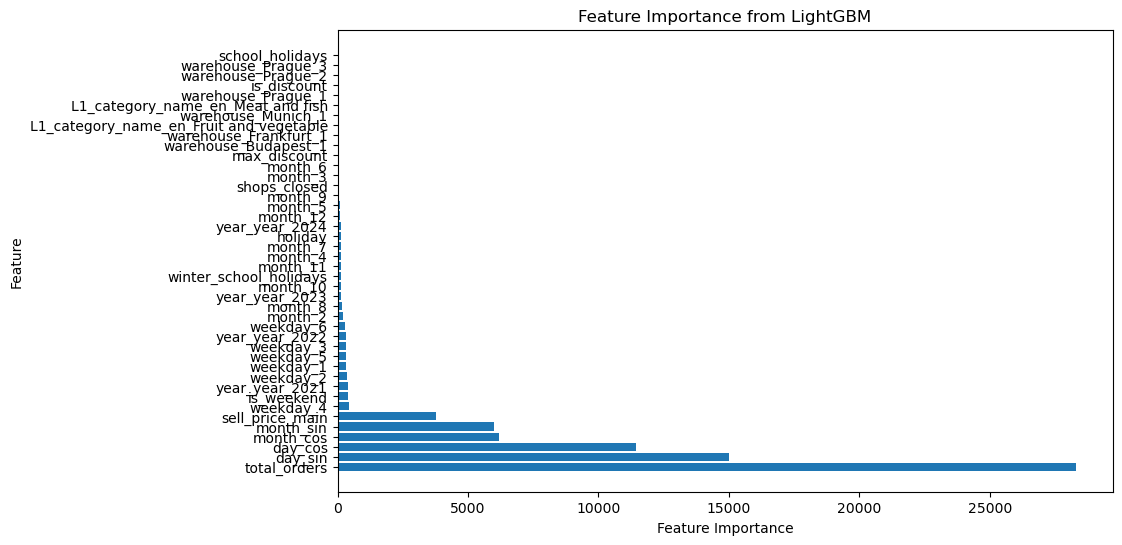

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from LightGBM')
plt.show()

In [16]:
import numpy as np
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# 计算分位数
bins = np.quantile(y_val, [0.33, 0.66])

# 将目标变量分为低、中、高三个区间
y_val_binned = np.digitize(y_val, bins)

# 输出区间范围
print(f'Low range: y_val < {bins[0]:.2f}')
print(f'Mid range: {bins[0]:.2f} <= y_val < {bins[1]:.2f}')
print(f'High range: y_val >= {bins[1]:.2f}')

# 计算每个区间的 MAE
for i in range(3):
    mask = y_val_binned == i
    mae = mean_absolute_error(y_val[mask], y_pred[mask])
    print(f'MAE for bin {i}: {mae:.2f}')


Low range: y_val < 68.30
Mid range: 68.30 <= y_val < 87.94
High range: y_val >= 87.94
MAE for bin 0: 26.03
MAE for bin 1: 17.18
MAE for bin 2: 17.43


In [17]:
# # 读取数据
# test = pd.read_csv('test_encode.csv')
# test_date = test['date']
# test.drop(['unique_id','date'], axis=1, inplace=True)
# t_pred = model.predict(test)

In [18]:
# # 计算分位数
# bins = np.quantile(t_pred, [0.33, 0.66])

# # 将目标变量分为低、中、高三个区间
# t_pred_binned = np.digitize(t_pred, bins)

# # 输出区间范围
# print(f'Low range: t_pred < {bins[0]:.2f}')
# print(f'Mid range: {bins[0]:.2f} <= t_pred < {bins[1]:.2f}')
# print(f'High range: t_pred >= {bins[1]:.2f}')

In [19]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# test['sales'] = t_pred
# test['date'] = test_date
# # 绘制图形
# plt.figure(figsize=(15, 8))

# # 绘制第一个验证集的实际销售数据（黄色）
# sns.lineplot(data=test, x='date', y='sales', color='yellow', label='Validation True Sales')

# # 添加标题和标签
# plt.title('Validation Set: True vs Predicted Sales (2023-2024)')
# plt.xlabel('Date')
# plt.ylabel('Sales')
# plt.legend()
# plt.grid()
# plt.show()

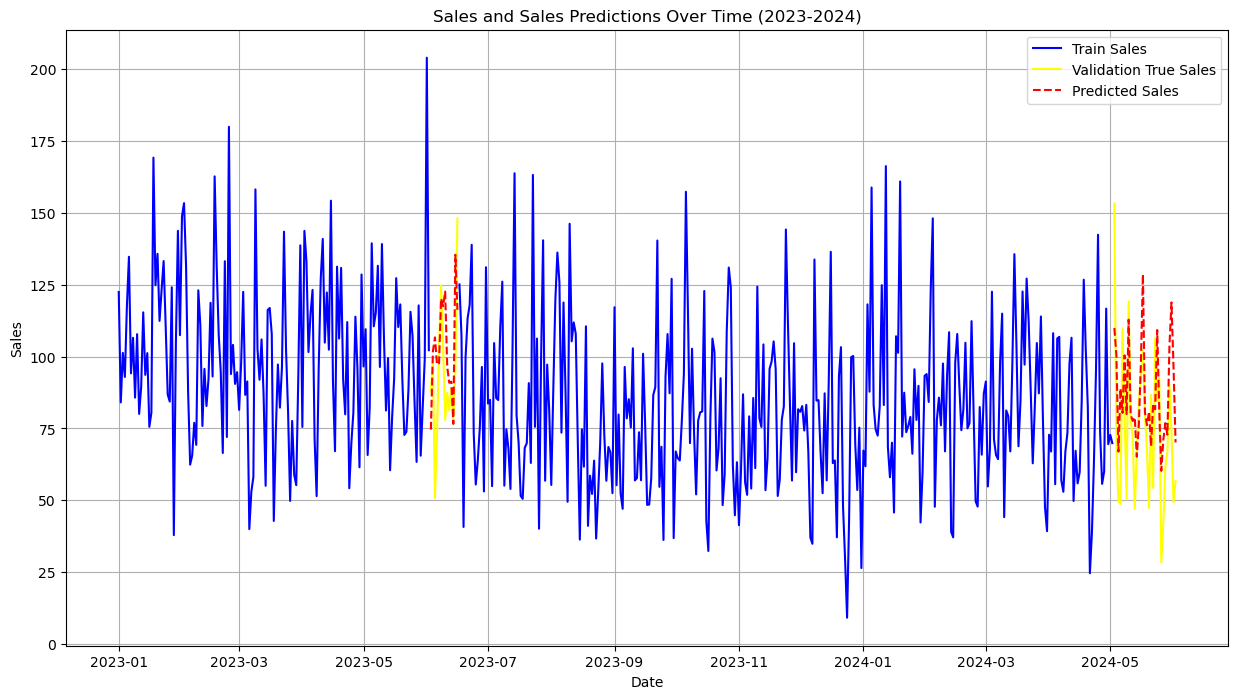

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 定义验证集的日期范围
val_start_date1 = pd.to_datetime('2023-06-03')
val_end_date1 = pd.to_datetime('2023-06-16')

val_start_date2 = pd.to_datetime('2024-05-03')
val_end_date2 = pd.to_datetime('2024-06-03')

train['date'] = train_date
val['date'] = val_date

train['sales'] = y_train
val['sales'] = y_val
# 确保 train 和 val 的 date 列是 datetime 类型
train['date'] = pd.to_datetime(train['date'])
val['date'] = pd.to_datetime(val['date'])

# 将预测值添加到验证集中
val['sales_hat'] = y_pred

# 划分训练集为多个部分
train_before_val1 = train[train['date'] < val_start_date1]  # 第一个验证集之前的数据
train_between_vals = train[(train['date'] > val_end_date1) & (train['date'] < val_start_date2)]  # 两个验证集之间的数据
train_after_val2 = train[train['date'] > val_end_date2]  # 第二个验证集之后的数据

# 划分验证集为多个部分
val1 = val[(val['date'] >= val_start_date1) & (val['date'] <= val_end_date1)]  # 第一个验证集
val2 = val[(val['date'] >= val_start_date2) & (val['date'] <= val_end_date2)]  # 第二个验证集

# 仅保留 2023 年和 2024 年的数据
train_before_val1 = train_before_val1[train_before_val1['date'].dt.year.isin([2023, 2024])]
train_between_vals = train_between_vals[train_between_vals['date'].dt.year.isin([2023, 2024])]
train_after_val2 = train_after_val2[train_after_val2['date'].dt.year.isin([2023, 2024])]
val1 = val1[val1['date'].dt.year.isin([2023, 2024])]
val2 = val2[val2['date'].dt.year.isin([2023, 2024])]

# 绘制图形
plt.figure(figsize=(15, 8))

# 绘制第一个验证集之前训练集的实际销售数据（蓝色）
sns.lineplot(data=train_before_val1, x='date', y='sales', color='blue', label='Train Sales ')

# 绘制两个验证集之间训练集的实际销售数据（蓝色）
sns.lineplot(data=train_between_vals, x='date', y='sales', color='blue')

# 绘制第二个验证集之后训练集的实际销售数据（蓝色）
sns.lineplot(data=train_after_val2, x='date', y='sales', color='blue')

# 绘制第一个验证集的实际销售数据（黄色）
sns.lineplot(data=val1, x='date', y='sales', color='yellow', label='Validation True Sales')

# 绘制第二个验证集的实际销售数据（黄色）
sns.lineplot(data=val2, x='date', y='sales', color='yellow')

# 绘制第一个验证集的预测销售数据（红色虚线）
sns.lineplot(data=val1, x='date', y='sales_hat', color='red', linestyle='--', label='Predicted Sales')

# 绘制第二个验证集的预测销售数据（红色虚线）
sns.lineplot(data=val2, x='date', y='sales_hat', color='red', linestyle='--')

# 添加标题和标签
plt.title('Sales and Sales Predictions Over Time (2023-2024)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.show()

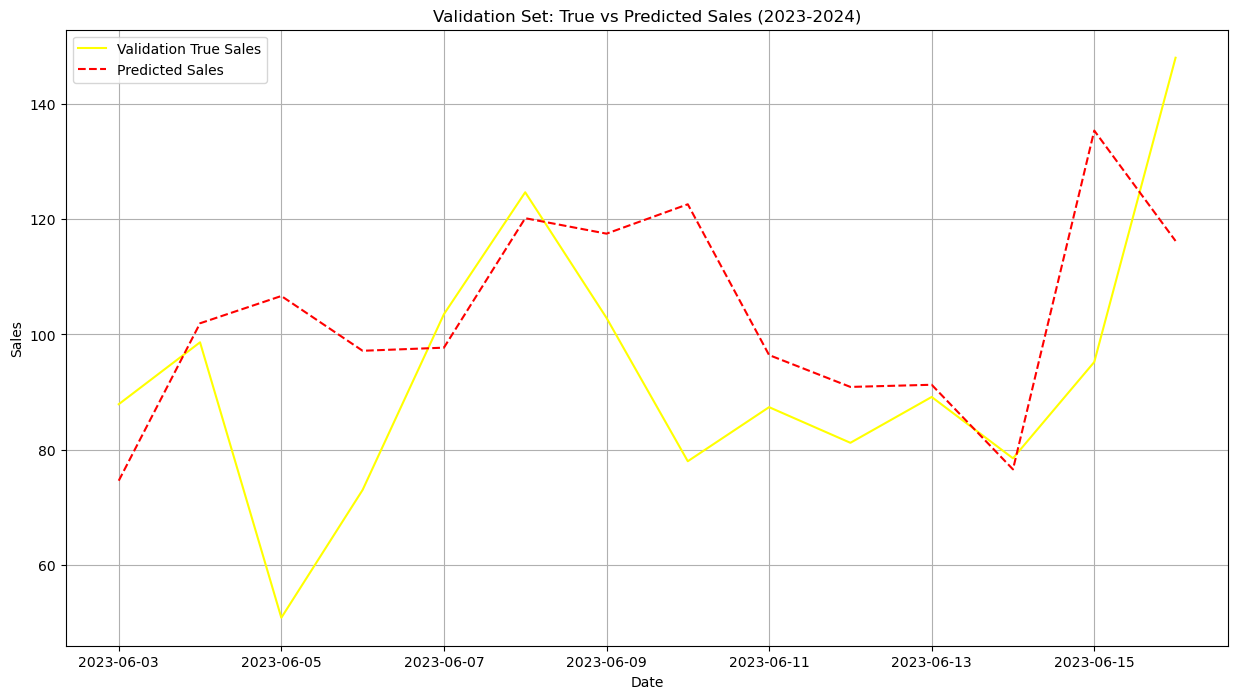

In [21]:
# 绘制图形
plt.figure(figsize=(15, 8))

# 绘制第一个验证集的实际销售数据（黄色）
sns.lineplot(data=val1, x='date', y='sales', color='yellow', label='Validation True Sales')

# 绘制第一个验证集的预测销售数据（红色虚线）
sns.lineplot(data=val1, x='date', y='sales_hat', color='red', linestyle='--', label='Predicted Sales')

# 添加标题和标签
plt.title('Validation Set: True vs Predicted Sales (2023-2024)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.show()

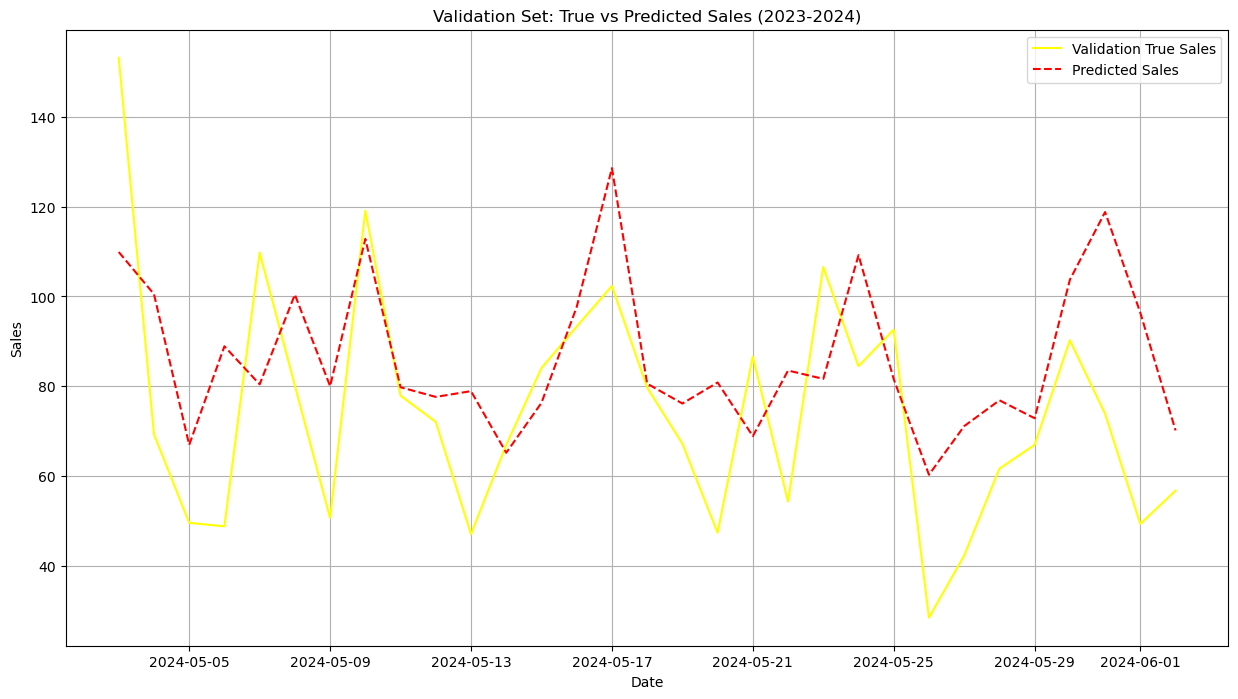

In [22]:
# 绘制图形
plt.figure(figsize=(15, 8))

# 绘制第二个验证集的实际销售数据（黄色）
sns.lineplot(data=val2, x='date', y='sales', color='yellow', label='Validation True Sales')

# 绘制第二个验证集的预测销售数据（红色虚线）
sns.lineplot(data=val2, x='date', y='sales_hat', color='red', linestyle='--', label='Predicted Sales')

# 添加标题和标签
plt.title('Validation Set: True vs Predicted Sales (2023-2024)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.show()